### Build CNN Conditional GAN to generate synthetic cifar 10 data
Proposed Conditional GAN label embedding: embed labels to generator, add classification head to discriminator

In [1]:
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms, datasets
from torch import optim as optim
import torch.nn.functional as F

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
training_parameters = {
    "n_epochs": 100,
    "batch_size": 100,
}
data_loader = torch.utils.data.DataLoader(
  
datasets.MNIST('./', train=True, download=True,
                         transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(
                             (0.5,), (0.5,))
                         ])),
batch_size=training_parameters["batch_size"], shuffle=True)

torch.Size([100, 1, 28, 28])


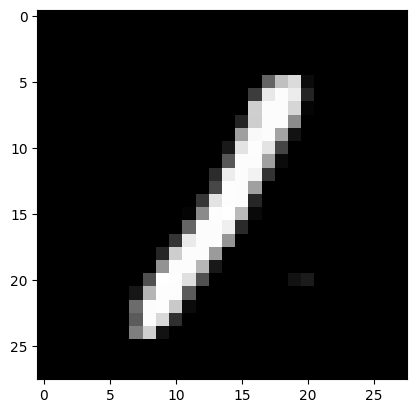

In [4]:
%matplotlib inline 
from matplotlib import pyplot as plt

for x,_ in data_loader:
    print(x.shape)
    plt.imshow(x.numpy()[0][0], cmap='gray')
    break

tensor([3, 0, 8, 4, 7, 0, 3, 0, 5, 7, 0, 1, 7, 5, 2, 6, 5, 5, 0, 1, 6, 7, 9, 7,
        1, 5, 1, 9, 3, 9, 4, 0, 9, 7, 6, 8, 2, 5, 3, 6, 1, 9, 0, 9, 0, 2, 5, 9,
        3, 5, 8, 8, 0, 1, 1, 2, 0, 3, 7, 5, 6, 5, 8, 7, 2, 1, 6, 0, 0, 8, 2, 1,
        5, 3, 8, 5, 0, 1, 3, 9, 2, 6, 3, 7, 3, 8, 7, 0, 9, 1, 7, 5, 0, 1, 4, 2,
        0, 6, 1, 8])


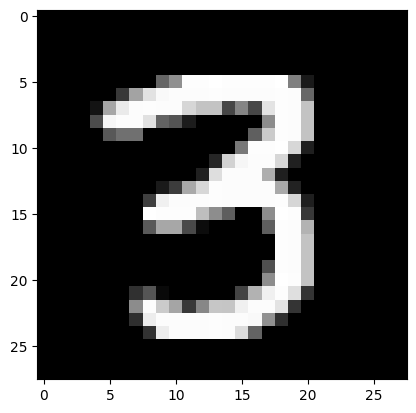

In [5]:
for x, label in data_loader:
    print(label)
    plt.imshow(x.numpy()[0][0], cmap='gray')
    break

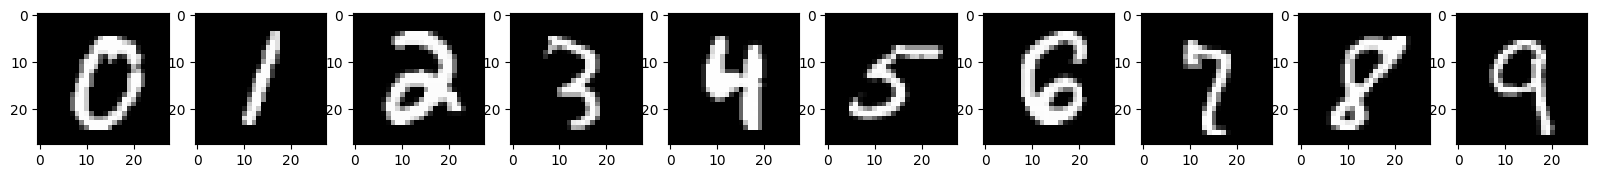

In [6]:
count = 0
fig, axs = plt.subplots(1, 10, figsize=(20,2))
for i, l in enumerate(label):
    if l == count:
        axs[count].imshow(x.numpy()[i][0], interpolation='nearest',cmap='gray')
        count += 1
    if count == 10:
        break
fig.savefig(f'mnist_real.pdf')

In [7]:
class Generator1(nn.Module):
    def __init__(self):
        super(Generator1, self).__init__()
        image_size = 28
        latent_dim = 100
        output_channels = 1
        self.init_size = image_size // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))
        self.label_embedding = nn.Embedding(10, 10)
        self.l2 = nn.Linear(10, self.init_size * self.init_size)

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(129),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(129, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, output_channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z, labels):
# #         print(z.shape)
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size) # bh, 128, 8, 8
# #         print(out.shape)
        
        li = self.label_embedding(labels)
# #         print(li.shape)
        li = self.l2(li)
# #         print(li.shape)
        li = li.view(labels.shape[0], 1, self.init_size, self.init_size)
# #         print(li.shape)
        out = torch.cat([out, li], 1)
# #         print(out.shape)
        
        img = self.conv_blocks(out)
# #         print(img.shape)
        return img
'''
z shape torch.Size([100, 100])
z shape after view torch.Size([100, 128, 7, 7])
label embedding shape torch.Size([100, 10])
label embedding after l2 torch.Size([100, 49])
label embedding after view torch.Size([100, 1, 7, 7])
concatenate z and label embedding torch.Size([100, 129, 7, 7])
after convolution layers torch.Size([100, 1, 28, 28])
'''

'\nz shape torch.Size([100, 100])\nz shape after view torch.Size([100, 128, 7, 7])\nlabel embedding shape torch.Size([100, 10])\nlabel embedding after l2 torch.Size([100, 49])\nlabel embedding after view torch.Size([100, 1, 7, 7])\nconcatenate z and label embedding torch.Size([100, 129, 7, 7])\nafter convolution layers torch.Size([100, 1, 28, 28])\n'

In [8]:
class Discriminator1(nn.Module):
    def __init__(self):
        super(Discriminator1, self).__init__()
        self.image_size = 28
        self.output_channels = 1
        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(self.output_channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )
        # The height and width of downsampled image
        ds_size = self.image_size // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(512, 1), nn.Sigmoid())
        self.cls_layer = nn.Linear(512, 10)

    def forward(self, img):
        
        out = self.model(img)
#         print(out.shape)
        out = out.view(out.shape[0], -1)
#         print(out.shape)
        out_adv = self.adv_layer(out)
        out_cls = self.cls_layer(out)
#         print(f'out_adv.shape {out_adv.shape}')  # [100, 1]
#         print(f'out_cls.shape {out_cls.shape}')  # [100, 10]
#         print(validity)

        return out_adv, out_cls

'''
image shape torch.Size([100, 1, 28, 28])
label embedding after l1 shape torch.Size([100, 784])
label embedding after reshape torch.Size([100, 1, 28, 28])
concatenate image and label embedding torch.Size([100, 2, 28, 28])
feature map size after convolution layers torch.Size([100, 128, 2, 2])
feature map to dense layer torch.Size([100, 512])
'''

'\nimage shape torch.Size([100, 1, 28, 28])\nlabel embedding after l1 shape torch.Size([100, 784])\nlabel embedding after reshape torch.Size([100, 1, 28, 28])\nconcatenate image and label embedding torch.Size([100, 2, 28, 28])\nfeature map size after convolution layers torch.Size([100, 128, 2, 2])\nfeature map to dense layer torch.Size([100, 512])\n'

In [9]:
discriminator1 = Discriminator1()
generator1 = Generator1()
discriminator1.to(device)
generator1.to(device)

Generator1(
  (l1): Sequential(
    (0): Linear(in_features=100, out_features=6272, bias=True)
  )
  (label_embedding): Embedding(10, 10)
  (l2): Linear(in_features=10, out_features=49, bias=True)
  (conv_blocks): Sequential(
    (0): BatchNorm2d(129, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode='nearest')
    (2): Conv2d(129, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Upsample(scale_factor=2.0, mode='nearest')
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Tanh()
  )
)

In [10]:
def train(generator, discriminator, data_loader, model_name="cnn_stargan"):
    n_epochs = 100
    batch_size = 100
    discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
    generator_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
    lambda_cls = 1

    adv_criterion = nn.BCELoss()
    cls_criterion = nn.CrossEntropyLoss()
    
    for epoch_idx in range(n_epochs):
        G_loss = []
        D_loss = []
        for batch_idx, data_input in enumerate(data_loader):


            noise = torch.randn(batch_size,100).to(device)
            fake_labels = torch.randint(0, 10, (batch_size,)).to(device)
#             print(f'fake_labels shape {fake_labels.shape}') # [100]
            generated_data = generator(noise, fake_labels)


            # Discriminator
            true_data = data_input[0].to(device)
            digit_labels = data_input[1].to(device) # batch_size
#             print(f'digit_labels shape {digit_labels.shape}') # [100]
#             true_labels = torch.ones(batch_size).to(device)

            discriminator_optimizer.zero_grad()

            r_out_adv, r_out_cls = discriminator(true_data)
            r_adv_loss = adv_criterion(r_out_adv.view(batch_size), torch.ones(batch_size).to(device))
            r_cls_loss = cls_criterion(r_out_cls, digit_labels)

            f_out_adv, f_out_cls = discriminator(generated_data.detach())
            f_adv_loss = adv_criterion(f_out_adv.view(batch_size), torch.zeros(batch_size).to(device))
            d_loss = r_adv_loss + f_adv_loss + lambda_cls * r_cls_loss

            d_loss.backward()
            discriminator_optimizer.step()

            D_loss.append(d_loss.data.item())


            # Generator

            generator_optimizer.zero_grad()
            # It's a choice to generate the data again
            generated_data = generator(noise, fake_labels)
            g_out_adv, g_out_cls = discriminator(generated_data)
            g_adv_loss = adv_criterion(g_out_adv.view(batch_size), torch.ones(batch_size).to(device))
            g_cls_loss = cls_criterion(g_out_cls, fake_labels)
            g_loss = g_adv_loss + lambda_cls * g_cls_loss
            g_loss.backward()
            generator_optimizer.step()
            
            G_loss.append(g_loss.data.item())
            
            
            if ((batch_idx + 1)% 500 == 0 and (epoch_idx + 1)%10 == 0):
                print("Training Steps Completed: ", batch_idx)

                with torch.no_grad():
                    noise = torch.randn(batch_size,100).to(device)
                    fake_labels = torch.randint(0, 10, (batch_size,)).to(device)
                    generated_data = generator(noise, fake_labels).cpu().view(batch_size, 28, 28)
                    for x in generated_data:
                        print(fake_labels[0].item())
                        plt.imshow(x.detach().numpy(), interpolation='nearest',cmap='gray')
                        plt.show()
                        break


        print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
                (epoch_idx), n_epochs, torch.mean(torch.FloatTensor(D_loss)), torch.mean(torch.FloatTensor(G_loss))))
        torch.save(generator, f'./{model_name}.pt')

[0/100]: loss_d: 1.924, loss_g: 2.422
[1/100]: loss_d: 1.352, loss_g: 1.562
[2/100]: loss_d: 1.193, loss_g: 1.610
[3/100]: loss_d: 1.136, loss_g: 1.532
[4/100]: loss_d: 1.131, loss_g: 1.475
[5/100]: loss_d: 1.112, loss_g: 1.480
[6/100]: loss_d: 1.125, loss_g: 1.413
[7/100]: loss_d: 1.168, loss_g: 1.373
[8/100]: loss_d: 1.197, loss_g: 1.279
Training Steps Completed:  499
6


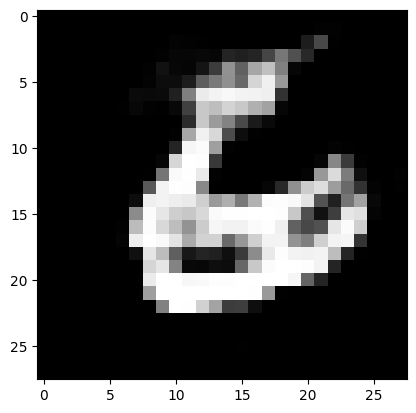

[9/100]: loss_d: 1.209, loss_g: 1.241
[10/100]: loss_d: 1.266, loss_g: 1.175
[11/100]: loss_d: 1.283, loss_g: 1.117
[12/100]: loss_d: 1.290, loss_g: 1.083
[13/100]: loss_d: 1.298, loss_g: 1.063
[14/100]: loss_d: 1.311, loss_g: 1.052
[15/100]: loss_d: 1.315, loss_g: 1.025
[16/100]: loss_d: 1.325, loss_g: 1.023
[17/100]: loss_d: 1.332, loss_g: 1.003
[18/100]: loss_d: 1.331, loss_g: 0.992
Training Steps Completed:  499
3


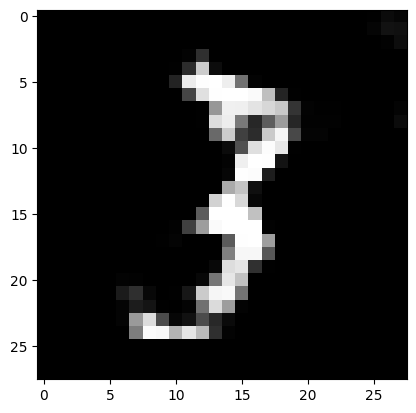

KeyboardInterrupt: 

In [11]:
train(generator1, discriminator1, data_loader)

In [ ]:
with torch.no_grad():
    noise = torch.randn(10,100).to(device)
    fake_labels = torch.randint(0, 10, (10,)).to(device)
    generated_data = generator1(noise, fake_labels).cpu().view(10, 28, 28)
    for i, x in enumerate(generated_data):
        print(fake_labels[i].item())
        plt.imshow(x.detach().numpy(), interpolation='nearest',cmap='gray')
        plt.show()

In [ ]:
#load model and generate 0 - 9 images
def draw_images(model_name):
    generator = torch.load(model_name)
    with torch.no_grad():
        noise = torch.randn(10,100).to(device)
        labels = torch.IntTensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).to(device)
#         labels = torch.range(0, 9)
        generated_data = generator(noise, labels).cpu().view(10, 28, 28)

    fig, axs = plt.subplots(1, 10, figsize=(20,2))
    for i in range(10):
        axs[i].imshow(generated_data[i].detach().numpy(), interpolation='nearest',cmap='gray')
    fig.savefig(f'{model_name}_syn.pdf')

In [ ]:
draw_images('cnn_cgan.pt')